In [ ]:

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
# import torchtoolbox.transform as transforms
from torchvision import models, transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
import gc
import os
# import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
# %matplotlib inline

In [2]:
#https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords#Step-2:-Data-Augmentation
#https://www.kaggle.com/code/nroman/melanoma-pytorch-starter-efficientnet/notebook
# DEVICE = "GPU"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cdeotte/jpeg-melanoma-1024x1024")

print("Path to dataset files:", path)

c:\Users\Gugu\Desktop\UCL\Biomed\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Gugu\.cache\kagglehub\datasets\cdeotte\jpeg-melanoma-1024x1024\versions\2


In [5]:
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
test_df =  pd.read_csv(os.path.join(path, 'test.csv'))


train_df = train_df[0:1000]
test_df = test_df[0:1000]

In [6]:
train_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000
...,...,...,...,...,...,...,...,...,...,...,...
995,ISIC_0405163,IP_7991448,male,85.0,torso,unknown,benign,0,13,3888,2592
996,ISIC_0405211,IP_6977878,male,30.0,lower extremity,unknown,benign,0,8,640,480
997,ISIC_0405253,IP_4366959,female,35.0,torso,unknown,benign,0,13,6000,4000
998,ISIC_0405554,IP_6049920,female,50.0,torso,unknown,benign,0,0,640,480



Summary Statistics:
--------------------------------------------------

Class Distribution:
Benign (0): 98.3%
Malignant (1): 1.7%

Age Statistics by Target:
        count       mean        std   min   25%   50%   75%   max
target                                                           
0       978.0  49.161554  14.736251  15.0  40.0  50.0  60.0  90.0
1        17.0  57.941176  17.415764  25.0  50.0  60.0  70.0  80.0

Anatomical Site Distribution by Target:
target                              0     1
anatom_site_general_challenge              
head/neck                       96.55  3.45
lower extremity                 98.33  1.67
oral/genital                   100.00  0.00
palms/soles                    100.00  0.00
torso                           98.85  1.15
upper extremity                 96.69  3.31

Gender Distribution by Target:
target      0     1
sex                
female  98.95  1.05
male    97.69  2.31

Missing Value Analysis:
                                                

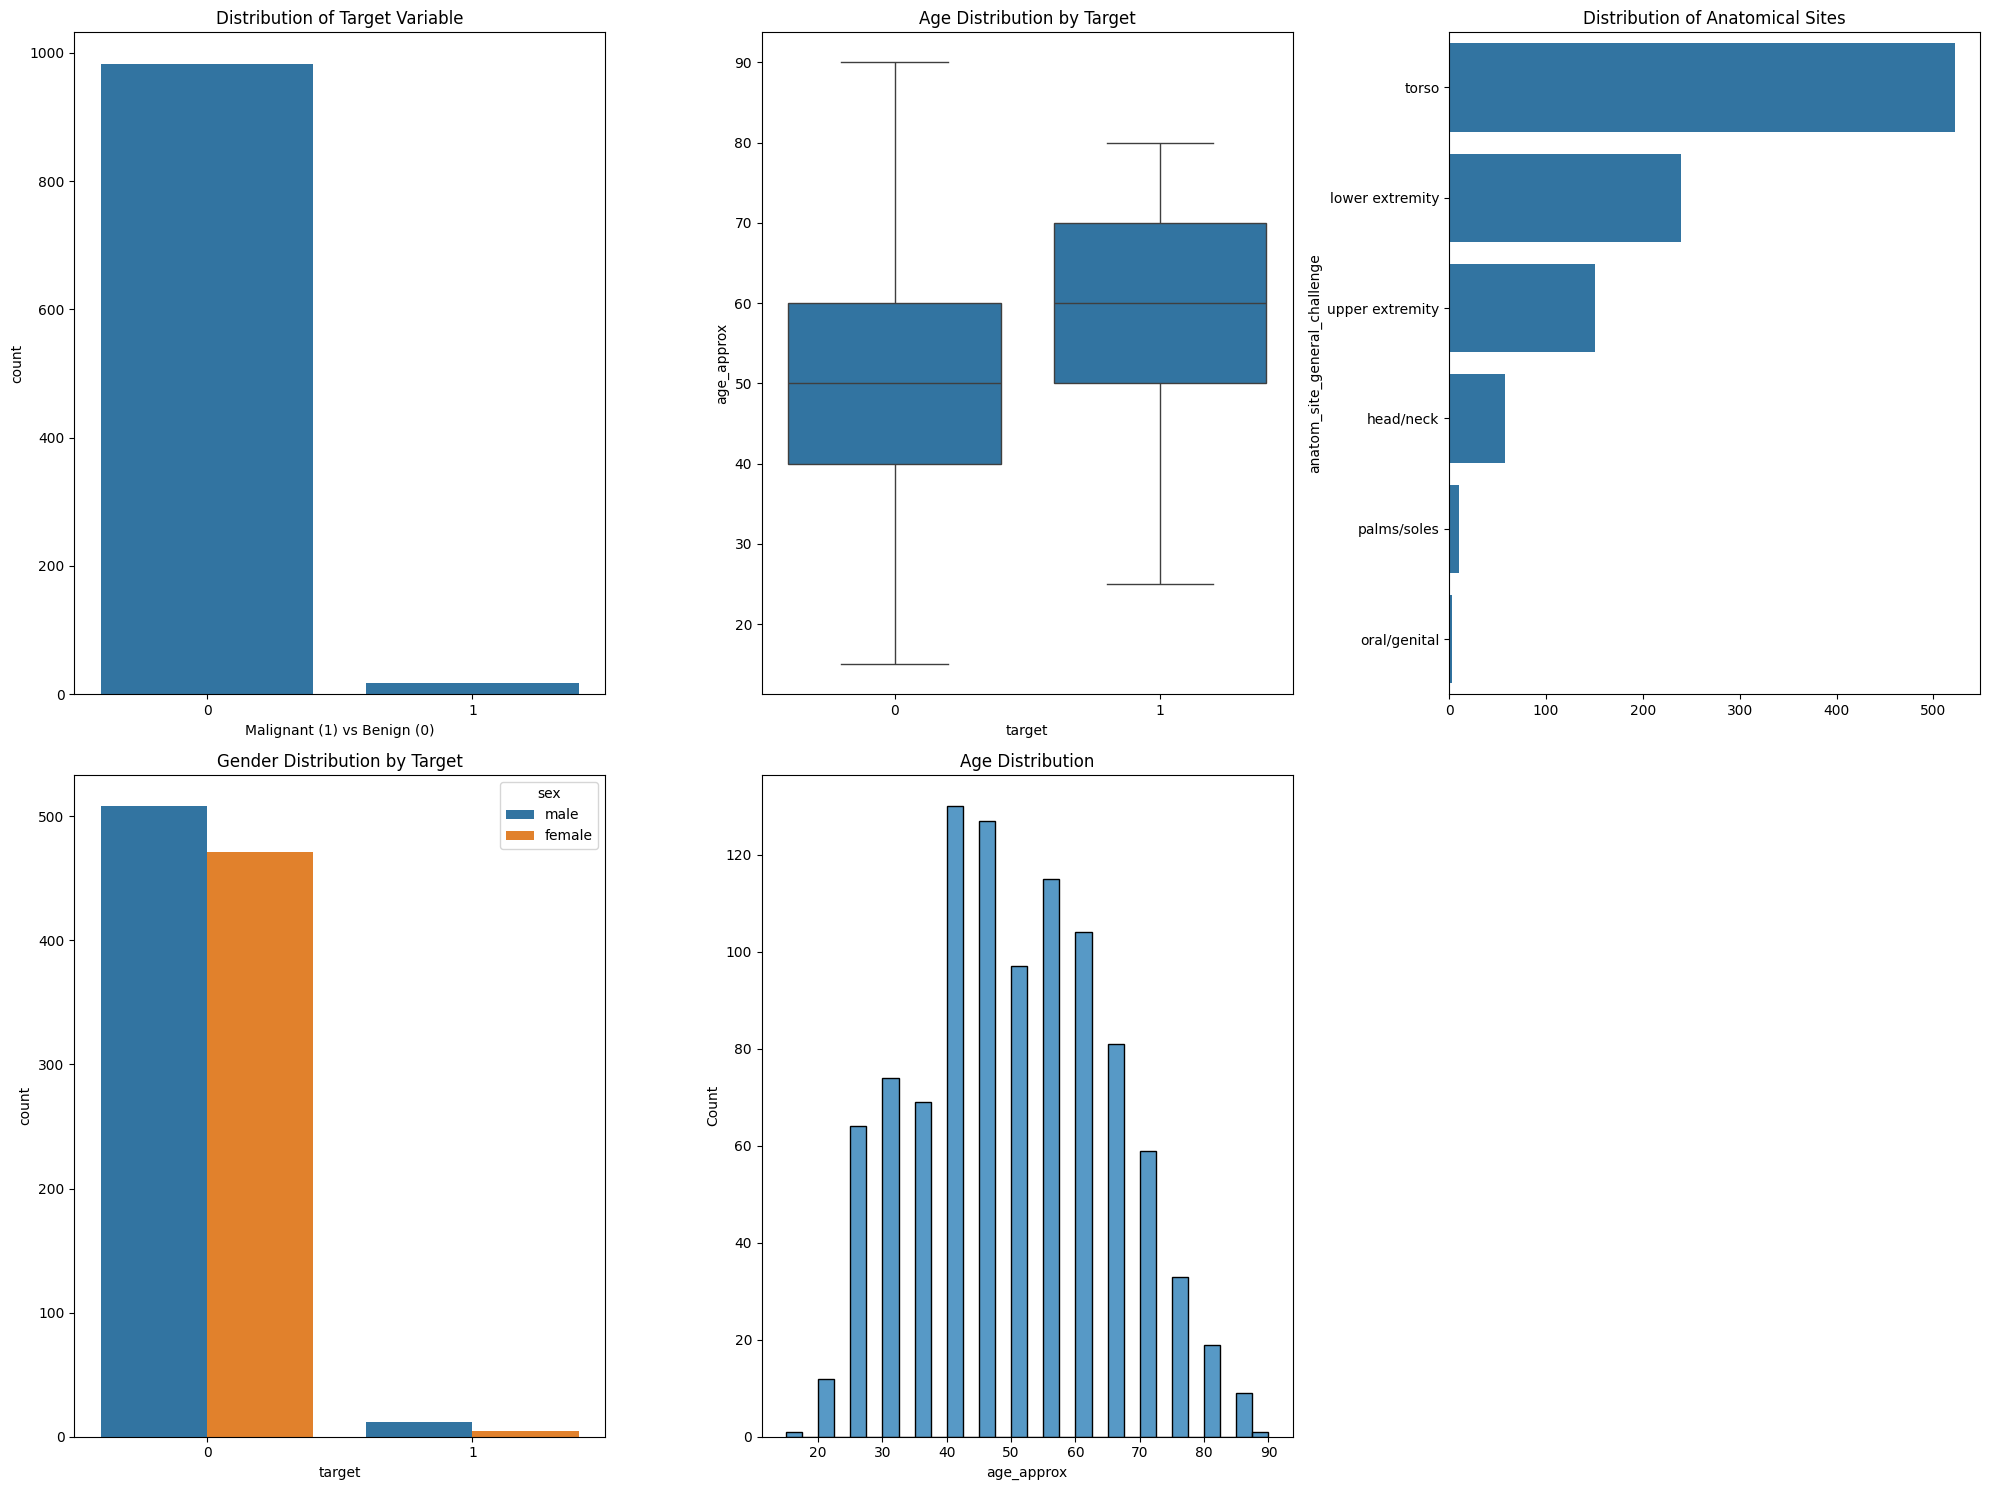

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def analyze_melanoma_data(train_df):
    # Set the style for all plots
    # plt.style.use('darkgrid')
    
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Distribution of target variable
    plt.subplot(2, 3, 1)
    sns.countplot(data=train_df, x='target')
    plt.title('Distribution of Target Variable')
    plt.xlabel('Malignant (1) vs Benign (0)')
    
    # 2. Age distribution by target
    plt.subplot(2, 3, 2)
    sns.boxplot(data=train_df, x='target', y='age_approx')
    plt.title('Age Distribution by Target')
    
    # 3. Anatomical site distribution
    plt.subplot(2, 3, 3)
    site_counts = train_df['anatom_site_general_challenge'].value_counts()
    sns.barplot(x=site_counts.values, y=site_counts.index)
    plt.title('Distribution of Anatomical Sites')
    
    # 4. Gender distribution by target
    plt.subplot(2, 3, 4)
    sns.countplot(data=train_df, x='target', hue='sex')
    plt.title('Gender Distribution by Target')
    
    # 5. Age distribution
    plt.subplot(2, 3, 5)
    sns.histplot(data=train_df, x='age_approx', bins=30)
    plt.title('Age Distribution')
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    
    # Calculate class imbalance
    target_dist = train_df['target'].value_counts(normalize=True)
    print(f"\nClass Distribution:")
    print(f"Benign (0): {target_dist[0]:.1%}")
    print(f"Malignant (1): {target_dist[1]:.1%}")
    
    # Age statistics by target
    print("\nAge Statistics by Target:")
    print(train_df.groupby('target')['age_approx'].describe())
    
    # Anatomical site distribution by target
    print("\nAnatomical Site Distribution by Target:")
    site_target = pd.crosstab(train_df['anatom_site_general_challenge'], 
                             train_df['target'], 
                             normalize='index') * 100
    print(site_target.round(2))
    
    # Gender distribution by target
    print("\nGender Distribution by Target:")
    gender_target = pd.crosstab(train_df['sex'], 
                               train_df['target'], 
                               normalize='index') * 100
    print(gender_target.round(2))
    
    return fig

# Create missing value analysis
def analyze_missing_values(df):
    missing = pd.DataFrame({
        'Column': df.columns,
        'Missing Values': df.isnull().sum(),
        'Missing Percentage': (df.isnull().sum() / len(df) * 100).round(2)
    })
    return missing.sort_values('Missing Percentage', ascending=False)

# Run the analysis
fig = analyze_melanoma_data(train_df)
missing_analysis = analyze_missing_values(train_df)
print("\nMissing Value Analysis:")
print(missing_analysis)

In [36]:
train_df[train_df['benign_malignant'] == 'malignant'][['sex', 'age_approx', 'target', 'site_palms/soles']]

,sex,age_approx,target,site_palms/soles
91,0.0,0.611111,1,0
235,0.0,0.555556,1,0
314,1.0,0.611111,1,0
399,1.0,0.722222,1,0
459,0.0,0.722222,1,0
475,1.0,0.833333,1,0
544,0.0,0.388889,1,0
546,1.0,0.888889,1,0
551,1.0,0.722222,1,0
558,1.0,0.333333,1,0


In [ ]:
train_df[['sex', 'age_approx', 'target', 'site_palms/soles']]

,sex,age_approx,target,site_palms/soles
0,1.0,0.500000,0,0
1,0.0,0.500000,0,0
2,0.0,0.555556,0,0
3,0.0,0.500000,0,0
4,0.0,0.611111,0,0
...,...,...,...,...
995,1.0,0.944444,0,0
996,1.0,0.333333,0,0
997,0.0,0.388889,0,0
998,0.0,0.555556,0,0


<h2>Dataset and DataLoaders

In [10]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        try:
            im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
            if not os.path.exists(im_path):
                raise FileNotFoundError(f"Image not found: {im_path}")
            # x = cv2.imread(im_path)
            # x = PIL.Image(im_path)
            # image_path: str = self.images['ALL'][idx]
            # Open image in grayscale mode (L) with PIL
            """Going to try and use PIL"""
            x = Image.open(im_path) #.convert('L')
            
            # print(f"Opened PIL image {im_path}")
            meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

            if self.transforms:
                x = self.transforms(x)
                
            if self.train:
                y = self.df.iloc[index]['target']
                return (x, meta), y
            else:
                return (x, meta)
        except Exception as e:
            print(f"Error loading image at index {index}: {str(e)}")
            # Return a dummy sample
            x = Image.new('RGB', (256, 256))
            meta = np.zeros(len(self.meta_features), dtype=np.float32)
            if self.train:
                return (x, meta), 0
            return (x, meta)        
    def display_image_index(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        # x = cv2.imread(im_path)
        # x = PIL.Image(im_path)
        # image_path: str = self.images['ALL'][idx]
        # Open image in grayscale mode (L) with PIL
        """Going to try and use PIL"""
        x = Image.open(im_path) #.convert('L')     
        display(x)
   
    
    def __len__(self):
        return len(self.df)
    
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        """ResNet with a linear layer???"""
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        """EfficientNet with a linear layer??"""
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        """Meta linear layers """
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

<h3>Transforms



In [11]:
train_transform = transforms.Compose([
    # AdvancedHairAugmentation(hairs_folder='/kaggle/input/melanoma-hairs'),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    # Microscope(p=0.5),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [12]:
# One-hot encoding of anatom_site_general_challenge feature
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_df['age_approx'] /= train_df['age_approx'].max()
test_df['age_approx'] /= test_df['age_approx'].max()
train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)

In [13]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [14]:
test = MelanomaDataset(df=test_df,
                       imfolder=os.path.join(path, 'test'), 
                       train=False,
                       transforms=train_transform,  # For TTA
                       meta_features=meta_features)

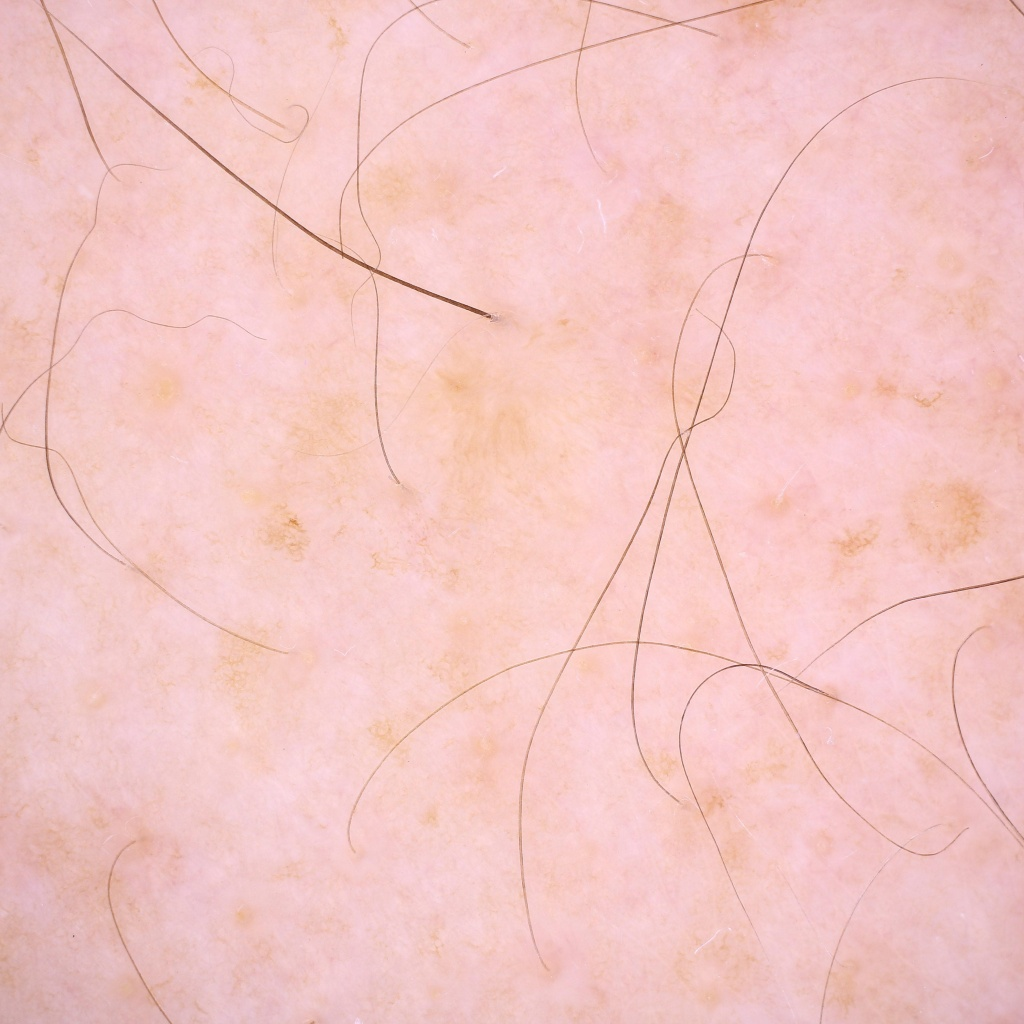

In [15]:
test.display_image_index(500)

In [16]:
skf = GroupKFold(n_splits=5)


In [17]:
arch = EfficientNet.from_pretrained('efficientnet-b1')

Loaded pretrained weights for efficientnet-b1


In [18]:
# epochs = 4  # Number of epochs to run
# es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
# TTA = 3 # Test Time Augmentation rounds

# oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
# preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

# skf = KFold(n_splits=2, shuffle=True, random_state=47)
# for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['patient_id'].tolist()), 1):
#     print('=' * 20, 'Fold', fold, '=' * 20)  
    
#     model_path = f'model_{fold}.pth'  # Path and filename to save model to
#     best_val = 0  # Best validation score within this fold
#     patience = es_patience  # Current patience counter
#     arch = EfficientNet.from_pretrained('efficientnet-b1')
#     model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
#     model = model.to(device)
    
#     optim = torch.optim.Adam(model.parameters(), lr=0.001)
#     scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
#     criterion = nn.BCEWithLogitsLoss()
    
#     train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
#                             imfolder=os.path.join(path, 'train'), 
#                             train=True, 
#                             transforms=train_transform,
#                             meta_features=meta_features)
#     val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
#                             imfolder=os.path.join(path, 'test'), 
#                             train=True, 
#                             transforms=test_transform,
#                             meta_features=meta_features)
    
#     train_loader = DataLoader(dataset=train, batch_size=16, shuffle=True, num_workers=0)
#     val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=0)
#     test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=0)
    
#     for epoch in range(epochs):
#         print(f"epoch {epoch} started")
#         start_time = time.time()
#         correct = 0
#         epoch_loss = 0
#         model.train()
        
#         for x, y in train_loader:
#             x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
#             x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
#             y = torch.tensor(y, device=device, dtype=torch.float32)
#             optim.zero_grad()
#             print("training on x")
#             z = model(x)
#             loss = criterion(z, y.unsqueeze(1))
#             loss.backward()
#             optim.step()
#             pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
#             correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
#             epoch_loss += loss.item()
#         train_acc = correct / len(train_idx)
#         print("Eval mode...")
#         model.eval()  # switch model to the evaluation mode
#         val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
#         with torch.no_grad():  # Do not calculate gradient since we are only predicting
#             # Predicting on validation set
#             for j, (x_val, y_val) in enumerate(val_loader):
#                 x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
#                 x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
#                 y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
#                 z_val = model(x_val)
#                 val_pred = torch.sigmoid(z_val)
#                 val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
#             val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
#             val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
#             print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
#             epoch + 1, 
#             epoch_loss, 
#             train_acc, 
#             val_acc, 
#             val_roc, 
#             str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
#             scheduler.step(val_roc)
                
#             if val_roc >= best_val:
#                 best_val = val_roc
#                 patience = es_patience  # Resetting patience since we have new best validation accuracy
#                 torch.save(model, model_path)  # Saving current best model
#             else:
#                 patience -= 1
#                 if patience == 0:
#                     print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
#                     break
                
#     model = torch.load(model_path)  # Loading best model of this fold
#     model.eval()  # switch model to the evaluation mode
#     val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
#     with torch.no_grad():
#         # Predicting on validation set once again to obtain data for OOF
#         for j, (x_val, y_val) in enumerate(val_loader):
#             x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
#             x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
#             y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
#             z_val = model(x_val)
#             val_pred = torch.sigmoid(z_val)
#             val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
#         oof[val_idx] = val_preds.cpu().numpy()
        
#         # Predicting on test set
#         tta_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)
#         for _ in range(TTA):
#             for i, x_test in enumerate(test_loader):
#                 x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
#                 x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
#                 z_test = model(x_test)
#                 z_test = torch.sigmoid(z_test)
#                 tta_preds[i*test_loader.batch_size:i*test_loader.batch_size + x_test[0].shape[0]] += z_test
#         preds += tta_preds / TTA
    
# preds /= skf.n_splits

In [19]:
epochs = 4
es_patience = 3
TTA = 3

# Initialize predictions
oof = np.zeros((len(train_df), 1))
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

skf = KFold(n_splits=2, shuffle=True, random_state=47)
for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target']), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)
    
    torch.cuda.empty_cache()
    
    model_path = f'model_{fold}.pth'
    best_val = 0
    patience = es_patience
    
    # Initialize model
    arch = EfficientNet.from_pretrained('efficientnet-b1')
    model = Net(arch=arch, n_meta_features=len(meta_features))
    model = model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    # Create datasets and loaders (unchanged)
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                           imfolder=os.path.join(path, 'train'), 
                           train=True, 
                           transforms=train_transform,
                           meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                         imfolder=os.path.join(path, 'train'), 
                         train=True, 
                         transforms=test_transform,
                         meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)
    
    for epoch in range(epochs):
        print(f"epoch {epoch} started")
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        # Training loop
        for i, (x, y) in enumerate(train_loader):
            # Transfer to GPU and ensure correct types
            x[0] = x[0].to(device, non_blocking=True)
            x[1] = x[1].to(device, non_blocking=True)
            y = y.float().to(device, non_blocking=True)  # Ensure y is float
            
            # Clear gradients
            optim.zero_grad(set_to_none=True)
            
            # Mixed precision training
            with torch.cuda.amp.autocast():
                z = model(x)
                loss = criterion(z, y.view(-1, 1))  # Use view instead of unsqueeze
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()
            
            # Calculate metrics
            with torch.no_grad():
                pred = torch.round(torch.sigmoid(z))
                correct += (pred == y.view(-1, 1)).sum().item()
                epoch_loss += loss.item()
            
            if i % 10 == 0:
                torch.cuda.empty_cache()
        
        train_acc = correct / len(train_idx)
        
        # Validation loop
        print("Eval mode...")
        model.eval()
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        
        with torch.no_grad():
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = x_val[0].to(device, non_blocking=True)
                x_val[1] = x_val[1].to(device, non_blocking=True)
                y_val = y_val.float().to(device, non_blocking=True)
                
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
            
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()).numpy())
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu().numpy())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
                epoch + 1, epoch_loss, train_acc, val_acc, val_roc,
                str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
            
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience
                torch.save(model.state_dict(), model_path)
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
        
        torch.cuda.empty_cache()
    
    # Load best model for predictions
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Final validation predictions
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = x_val[0].to(device, non_blocking=True)
            x_val[1] = x_val[1].to(device, non_blocking=True)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()
        
        # Test predictions with TTA
        tta_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = x_test[0].to(device, non_blocking=True)
                x_test[1] = x_test[1].to(device, non_blocking=True)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                tta_preds[i*test_loader.batch_size:i*test_loader.batch_size + x_test[0].shape[0]] += z_test
        preds += tta_preds / TTA
        
        torch.cuda.empty_cache()

preds /= skf.n_splits

C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:10: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
c:\Users\Gugu\Desktop\UCL\Biomed\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
epoch 0 started


C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autoca

Eval mode...
Epoch 001: | Loss: 5.480 | Train acc: 0.966 | Val acc: 0.978 | Val roc_auc: 0.522 | Training time: 0:00:45
epoch 1 started


C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autoca

Eval mode...
Epoch 002: | Loss: 2.668 | Train acc: 0.986 | Val acc: 0.978 | Val roc_auc: 0.480 | Training time: 0:00:44
epoch 2 started


C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autoca

Eval mode...
Epoch 003: | Loss: 1.559 | Train acc: 0.984 | Val acc: 0.978 | Val roc_auc: 0.645 | Training time: 0:00:45
epoch 3 started


C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autoca

Eval mode...
Epoch 004: | Loss: 1.900 | Train acc: 0.990 | Val acc: 0.978 | Val roc_auc: 0.490 | Training time: 0:00:44


C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


==================== Fold 2 ====================
Loaded pretrained weights for efficientnet-b1
epoch 0 started


c:\Users\Gugu\Desktop\UCL\Biomed\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` i

Eval mode...
Epoch 001: | Loss: 7.586 | Train acc: 0.944 | Val acc: 0.988 | Val roc_auc: 0.470 | Training time: 0:00:44
epoch 1 started


C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autoca

Eval mode...
Epoch 002: | Loss: 3.425 | Train acc: 0.976 | Val acc: 0.988 | Val roc_auc: 0.383 | Training time: 0:00:44
epoch 2 started


C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autoca

Eval mode...
Epoch 003: | Loss: 2.322 | Train acc: 0.976 | Val acc: 0.988 | Val roc_auc: 0.638 | Training time: 0:00:44
epoch 3 started


C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:65: FutureWarning: `torch.cuda.amp.autoca

Eval mode...
Epoch 004: | Loss: 2.404 | Train acc: 0.972 | Val acc: 0.988 | Val roc_auc: 0.507 | Training time: 0:00:44


C:\Users\Gugu\AppData\Local\Temp\ipykernel_51560\3086320845.py:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


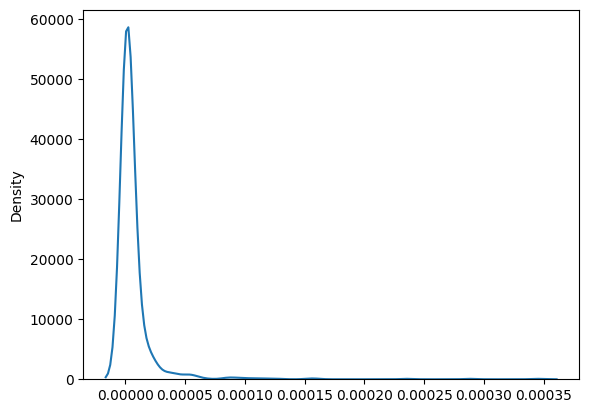

In [20]:
#Kernel Density Estimation. 
#Essentially just a histogram that is continuous

sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));


In [21]:
# # First, verify your data paths and DataFrame
# print("DataFrame info:")
# print(train_df.info())
# print("\nMeta features:", meta_features)
# print("\nFirst few rows of DataFrame:")
# print(train_df.head())

# # Create minimal transforms
# train_transform = transforms.Compose([
#     transforms.ToTensor()
# ])

# # Create dataset with error checking
# try:
#     train_dataset = MelanomaDataset(
#         df=train_df,
#         imfolder=os.path.join(path, 'train'),  # Verify this path!
#         train=True,
#         transforms=train_transform,
#         meta_features=meta_features
#     )
#     print("\nDataset created successfully")
# except Exception as e:
#     print(f"Failed to create dataset: {str(e)}")
#     raise

# # Test single sample loading
# print("\nTesting single sample loading:")
# try:
#     sample = train_dataset[0]
#     print("Successfully loaded first sample")
#     print(f"Sample types: {type(sample[0][0])}, {type(sample[0][1])}, {type(sample[1])}")
# except Exception as e:
#     print(f"Failed to load sample: {str(e)}")
#     raise

# # Create and test DataLoader with minimal settings
# try:
#     train_loader = DataLoader(
#         dataset=train_dataset,
#         batch_size=4,
#         shuffle=False,
#         num_workers=0,  # Set to 0 first to test without multiprocessing
#         pin_memory=True
#     )
#     print("\nDataLoader created successfully")
# except Exception as e:
#     print(f"Failed to create DataLoader: {str(e)}")
#     raise

# # Test batch loading
# print("\nTesting batch loading:")
# try:
#     first_batch = next(iter(train_loader))
#     print("Successfully loaded first batch")
#     print(f"Batch types: {type(first_batch[0][0])}, {type(first_batch[0][1])}, {type(first_batch[1])}")
# except Exception as e:
#     print(f"Failed to load batch: {str(e)}")
#     raise